# 自動運転モデル作成

## 必要なモジュールのインポート

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import random
# from imgaug import augmenters as iaa
# import cv2

Using TensorFlow backend.


## シード値の固定

In [2]:
np.random.seed(0)

## データを読み込みデータフレームに格納

In [3]:
# datadirにパスを代入
datadir = 'self_driving_data/data_30'

# データフレームのカラム名を設定
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

# パスをつけてデータを読み込みデータフレームに入れる
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)

# pd.set_option('display.max_colwidth', -1)#カラム名の位置を綺麗に見せる。

#表示
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/itotakeru/self_driving/IMG/center_2018_...,/Users/itotakeru/self_driving/IMG/left_2018_11...,/Users/itotakeru/self_driving/IMG/right_2018_1...,0.0,0.0,0.0,0.000008
1,/Users/itotakeru/self_driving/IMG/center_2018_...,/Users/itotakeru/self_driving/IMG/left_2018_11...,/Users/itotakeru/self_driving/IMG/right_2018_1...,0.0,0.0,0.0,0.000003
2,/Users/itotakeru/self_driving/IMG/center_2018_...,/Users/itotakeru/self_driving/IMG/left_2018_11...,/Users/itotakeru/self_driving/IMG/right_2018_1...,0.0,0.0,0.0,0.000005
3,/Users/itotakeru/self_driving/IMG/center_2018_...,/Users/itotakeru/self_driving/IMG/left_2018_11...,/Users/itotakeru/self_driving/IMG/right_2018_1...,0.0,0.0,0.0,0.000025
4,/Users/itotakeru/self_driving/IMG/center_2018_...,/Users/itotakeru/self_driving/IMG/left_2018_11...,/Users/itotakeru/self_driving/IMG/right_2018_1...,0.0,0.0,0.0,0.000002


## それぞれのフォルダ名を取り除く
各々のフォルダ名は必要ではない。


In [4]:
# 画像のフォルダ名とファイル名を取得しファイル名を返す関数を作成
def path_leaf(path):
    folder_name, file_name = os.path.split(path)
    return file_name

# 関数を適応しそれぞれを置き換える。
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_11_19_13_39_37_045.jpg,left_2018_11_19_13_39_37_045.jpg,right_2018_11_19_13_39_37_045.jpg,0.0,0.0,0.0,0.000008
1,center_2018_11_19_13_39_37_127.jpg,left_2018_11_19_13_39_37_127.jpg,right_2018_11_19_13_39_37_127.jpg,0.0,0.0,0.0,0.000003
2,center_2018_11_19_13_39_37_208.jpg,left_2018_11_19_13_39_37_208.jpg,right_2018_11_19_13_39_37_208.jpg,0.0,0.0,0.0,0.000005
3,center_2018_11_19_13_39_37_290.jpg,left_2018_11_19_13_39_37_290.jpg,right_2018_11_19_13_39_37_290.jpg,0.0,0.0,0.0,0.000025
4,center_2018_11_19_13_39_37_372.jpg,left_2018_11_19_13_39_37_372.jpg,right_2018_11_19_13_39_37_372.jpg,0.0,0.0,0.0,0.000002


## ステアリング(ハンドルの角度)をグラフに描写

どのようにデータが分布するか簡単にチェックする

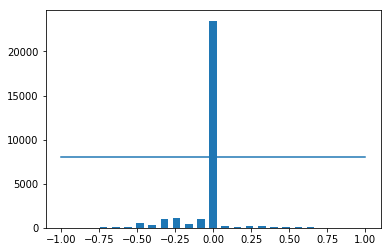

In [5]:
# ヒストグラムの設定
num_bins = 25
sample_per_bins = 8000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_per_bins, sample_per_bins))

## データのバランスを整える(仮)

ハンドルがまっすぐの状態のデータが、どちらかに曲がっている時のデータに比べ非常に多い。
学習時間の短縮のために多すぎる部分をカットする。

total data: 29261
removed: 15485
remaining: 13776


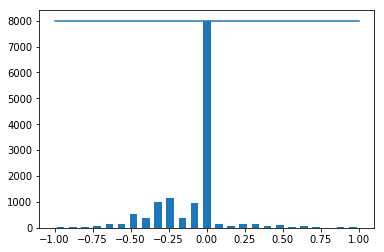

In [6]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[sample_per_bins:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_per_bins, sample_per_bins))

### トレーニングデータと検証データに分ける

学習に必要なデータは

１、centerの画像データ　

２、それに対応したハンドル角度のデータ　

だけであるので、それらを取り出し新たなリストを作成し、その後numpy配列に変更。

In [7]:
# 学習データとテストデータ分けるために、画像とハンドル角度(steering)のリストを作成
print(data.iloc[1])

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center= indexed_data[0]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir+'/IMG', data)

center      center_2018_11_19_13_39_37_617.jpg
left          left_2018_11_19_13_39_37_617.jpg
right        right_2018_11_19_13_39_37_617.jpg
steering                                     0
throttle                              0.339393
reverse                                      0
speed                                 0.328175
Name: 7, dtype: object


In [8]:
# 画像を訓練データ、ステアリングを教師データとしてデータを作成している
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 11020
Valid Samples: 2756


### 確認　
同じような割合で分かれているのでOK(数は決めた通りだいたい２割)

Text(0, 0.5, 'amount')

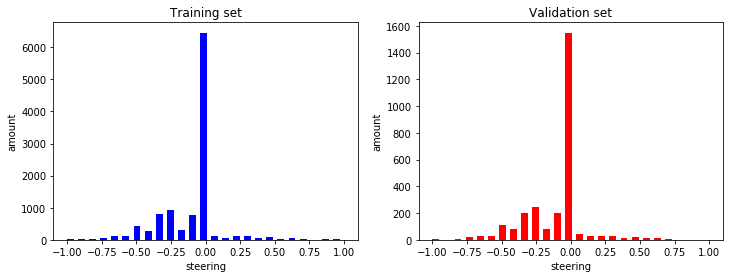

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[0].set_xlabel('steering')
axes[0].set_ylabel('amount')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')
axes[1].set_xlabel('steering')
axes[1].set_ylabel('amount')

## データの前処理
### 今回行った前処理
- カラー変更(YUV,GRAY)
- 画像から必要な道路の部分だけ切り抜く
- 画像の正規化

In [10]:
def img_preprocess(img):
    img = Image.open(img)
    # YUVカラーに変更、グレーに変更
    # 上部分を取り除いて道路のみを切り出す
    img = img.convert('YCbCr').convert("L").crop((0, 60, 320, 135)).resize((200, 66))
    # numpy配列に変換
    img = np.asarray(img)
    # 画像の正規化
    img = img/255 
    return img


ランダムで画像を選び、前処理の変化を確認。

(66, 200)


Text(0.5, 1.0, 'Preprocessed Image')

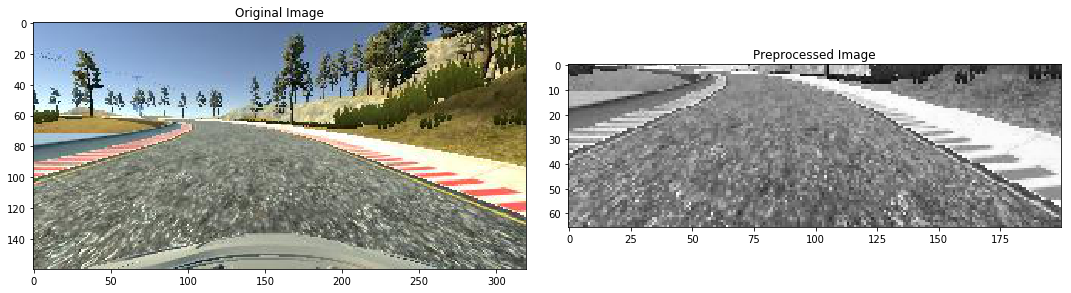

In [11]:
random_index = random.randint(0, len(X_train)-1)
image = image_paths[random_index]

original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

print(preprocessed_image.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
plt.gray()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

### 前処理を画像に適応

In [12]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

## ネットワークの構築
end to end learning (https://arxiv.org/abs/1604.07316)

### １０エポックごとにラーニングレートを半分にする関数を定義。
なぜ１０エポックごとに(学習が進むと)ラーニングレートを小さくする必要があるのか。

In [13]:
def schedule_lr(epoch):
    lr = 1e-3
    for ep in range(epoch):
        if ep % 10 == 0:
            lr /= 2
    return lr

### モデルの作成

CNNの説明

maxpoolingの説明

Dropoutの説明

In [14]:
def nvidia_model():
    # kerasのsequentialモデル
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu'))
    model.add(Convolution2D(32, 3, 3, subsample=(2, 2), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='relu')) 
    model.add(Dense(1))
    
    optimizer = Nadam()
    model.compile(loss="mse", optimizer=optimizer, metrics=['acc', 'mean_absolute_error'])
    return model

In [15]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 99, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 49, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 24, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 24, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 32)         9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 32)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 10, 32)         0         
__________

/Users/itotakeru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/Users/itotakeru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", strides=(2, 2))`
  """
/Users/itotakeru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  if __name__ == '__main__':
/Users/itotakeru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.


学習する画像をグレースケールにしたので、次元が少なくなった。

なので次元を追加し畳み込み層の次元数に合わせている。

In [16]:
X_train = np.expand_dims(X_train,  -1)
X_valid = np.expand_dims(X_valid, -1)

In [ ]:
from keras.callbacks import ModelCheckpoint

start = time.time()

model_checkpoint = ModelCheckpoint(
    filepath=os.path.join('/Users/itotakeru/lab/self_driving_using_udacity_sim/models', 'model_{epoch:02d}_{val_loss:.2f}.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

lr_scheduler = LearningRateScheduler(schedule_lr)

history = model.fit(X_train, y_train,epochs=50, validation_data=(X_valid, y_valid), batch_size=100, callbacks=[model_checkpoint, lr_scheduler])
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time/60) + "[min]")

In [ ]:
X_train = X_train.squeeze(-1)

In [ ]:
X_valid = X_valid.squeeze(-1)

In [ ]:
X_train.shape

In [ ]:
X_valid.shape